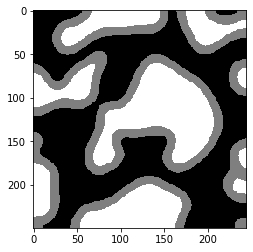

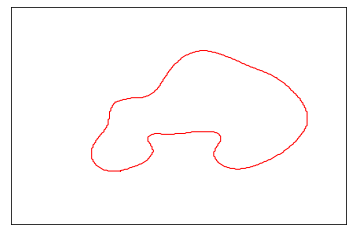

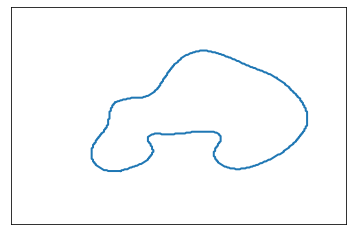

1 contours found

Area found = 12932, normalized area = 1, length found = 575
The mean curvature of curv2 = -0.01 (abs: 0.10) and the abs max = 0.71
The mean curvature of curv1 (error e-7) = 0.05 (abs: 0.33) and the abs max = 4.09
The mean curvature of curv1 (error e-6) = 0.10 (abs: 0.48) and the abs max = 8.37
The mean curvature of curv1 (error e-4) = -0.05 (abs: 0.50) and the abs max = 7.59
Continuity check (curv, startpoint, endpoint):
Curv2, 0.18, 0.00
Curv1e-7, -0.01, -0.55
Curv1e-6, -0.01, -0.55
curv1e-5, -0.02, -0.55


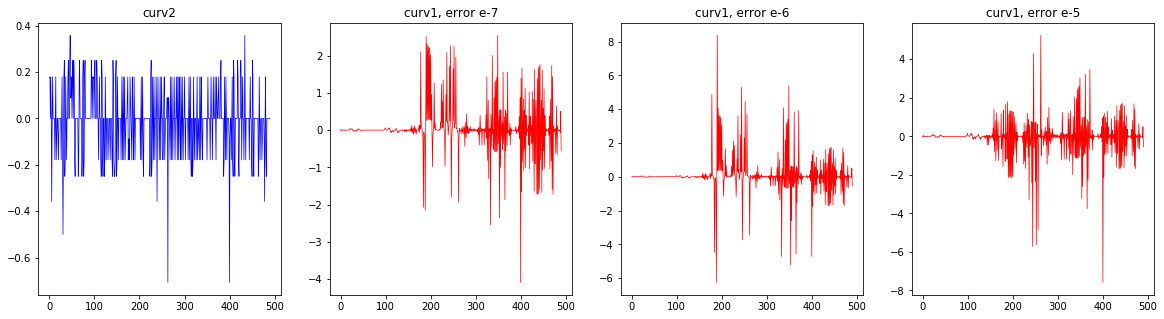

In [40]:
from __future__ import division, unicode_literals, print_function

import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2
# import cv2.floodfill

import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import pims
import trackpy as tp

from skimage.color import rgb2gray
import skimage.io as io # necessary for skimage.color.rgb2gray to function
from skimage.util import img_as_ubyte # for uint8 conversion
from skimage import measure # for the contour finding
from skimage import measure
from skimage.filters import threshold_otsu

import scipy as sp
import scipy.ndimage
from scipy import misc
from scipy.interpolate import UnivariateSpline

from os import path
from os import makedirs
from os import walk
from os import remove

import fnmatch
import shutil

import math
from PIL import Image

import sys, time


framesraw = [] # frames = tp.ImageSequence(mypath)
composite_contours = []               # create an empty array to store outlines results
sigmaffc = 57 # flat field correction sigma
ROI = [400, 650, 630, 875] # part we want to crop in y1, y2, x1, x2
kernel = np.ones((5,5)) # kernel used when 'closing' the image
bin_thresh = 175 # the binary threshold
save_path_contour = r"C:/Users/sharo/BSCtest/contours/" # where contours are saved
save_path_area = r"C:/Users/sharo/BSCtest/area-results/" # where area results are saved
shape_x = ROI[3] - ROI[2]
shape_y = ROI[1] - ROI[0]
time_scale = 1 # seconds/frame
space_scale = 1 # microns/pixel
extra_points = 100

def imageprocessing(frames, otsu):
    frames_prc = []
    for im in range(len(frames)):
        [ylow, yup, xleft, xright] = ROI
        imageraw = frames[im]
        imagecrop = imageraw[ylow:yup, xleft:xright]
        imageffc = imflatfield(imagecrop, sigmaffc)
        imagegray = img_as_ubyte(rgb2gray(imageffc)) # default returns float
        if otsu==True:
            thresh = threshold_otsu(imagegray)
        else:
            thresh = bin_thresh
        imagebin = cv2.threshold(imagegray, thresh, 2, cv2.THRESH_BINARY_INV)[1] # second output = image, second argument = threshold
        imagenoise = cv2.fastNlMeansDenoising(imagebin,50,50,21,21)
        imageclose = cv2.morphologyEx(imagenoise, cv2.MORPH_OPEN, kernel) # since binary = inverse
        frames_prc.append(imageclose)
        plt.figure()
        plt.imshow(imageclose,cmap='binary')
        plt.figure()
    return frames_prc

def imflatfield(I, sigma):
    
    # Format must be RGB and type uint8
    if I.dtype != 'uint8':
        I = img_as_ubyte(I)
    
    A = I.astype(np.float32) / 255  # A = im2single(I);
    Ihsv = cv2.cvtColor(A, cv2.COLOR_BGR2HSV)  # Ihsv = rgb2hsv(A);
    A = Ihsv[:, :, 2]  # A = Ihsv(:,:,3);

    filterSize = int(2*np.ceil(2*sigma) + 1);  # filterSize = 2*ceil(2*sigma)+1;

    # shading = imgaussfilt(A, sigma, 'Padding', 'symmetric', 'FilterSize', filterSize); % Calculate shading
    shading = cv2.GaussianBlur(A, (filterSize, filterSize), sigma, borderType=cv2.BORDER_REFLECT)

    meanVal = np.mean(A)  # meanVal = mean(A(:),'omitnan')

    #% Limit minimum to 1e-6 instead of testing using isnan and isinf after division.
    shading = np.maximum(shading, 1e-6)  # shading = max(shading, 1e-6);

    B = A*meanVal / shading  # B = A*meanVal./shading;

    #% Put processed V channel back into HSV image, convert to RGB
    Ihsv[:, :, 2] = B  # Ihsv(:,:,3) = B;

    B = cv2.cvtColor(Ihsv, cv2.COLOR_HSV2BGR)  # B = hsv2rgb(Ihsv);

    B = np.round(np.clip(B*255, 0, 255)).astype(np.uint8)  # B = im2uint8(B);

    return B

def pathexists(save_path):
    # Deletes folder if it already exists
    if path.exists(save_path):
        shutil.rmtree(save_path)
    makedirs(save_path) # creates folder

def contourtext(plot):
    i = 0
    for im in range(len(frames)):
        list_contours = []                #list containing the ID of contours to keep (closed ones in our case)
        
        imageclose = frames[im]
        contours = measure.find_contours(imageclose, 1) # 1 is intensity for which contour is sought
    
        for n in range(len(contours)):
            if contours[n][0,1]-contours[n][-1,1] == 0 and contours[n][0,0]-contours[n][-1,0] == 0 : # keep only closed contours
                composite_contours.append(contours[n])
                list_contours.append(n)
                if plot==True:
                    plt.plot(contours[n][:, 1], contours[n][:, 0], linewidth=1, color = 'r')
        if plot==True:
            plt.xlim(0, shape_x-1)
            plt.ylim(shape_y-1, 0)
            plt.xticks([])
            plt.yticks([])
            plt.savefig(save_path_contour + 'edges_000' + str(i) + '.jpg', dpi = 100, bbox_inches='tight')
            plt.show()
            plt.clf()
    
        # Make text file with data
        DataName = save_path_contour +'edges_000' + str(i) + '.txt'
        Data = open(DataName, 'w')
        j = 0
        for j in list_contours :    
            for k in range(len(contours[j])) :
                Data.write(str(im) + '\t')
                Data.write(str(j) + '\t')
                Data.write(str(contours[j][k,0]) + '\t')
                Data.write(str(contours[j][k,1]) + '\n')
        Data.close()
        i+=1
        
        return list_contours
    
def rainbowplot(frames, composite_contours): # plots contours around crystals with white background
    fig, ax = plt.subplots()
    ax.imshow(frames[-1], interpolation='nearest', cmap=plt.cm.gray)
    
    cmap = mpl.cm.get_cmap('gist_rainbow')
    
    for n, contour in enumerate(composite_contours):
        c = cmap(float(n)/(len(composite_contours)-1))
        plt.plot(contour[:, 1], contour[:, 0], linewidth=1, color = c)
    plt.xlim(0, shape_x-1)
    plt.ylim(shape_y-1, 0)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(save_path_contour + 'final-outline_frames.png', dpi = 100, bbox_inches='tight')
    plt.show()
    plt.clf()
    
def contourspart(plot):
    contours_part = []
    pattern    = '*.txt'        # extension of data files
    
    for root, dirs, files in walk(save_path_contour):
#         p = ProgressBar(len(files)) # initiate the progress bar
        i = 0 # index for the progress bar
        x_lim = 0
        for filename in fnmatch.filter(files, pattern):
            filename = save_path_contour+filename
            contour = np.loadtxt(filename, dtype=float, delimiter='\t', usecols=(0,1,3,2), unpack=True) # load txt file
            contours_part.append(contour)
    
    curvatures1 = []
    curvatures2 = []
    curvatures1b = []
    curvatures1c = []
    for im in range(len(contours_part)):
        curv1 = []
        curv2 = []
        curv1b = []
        curv1c = []
        k_part = 0
        for n in list(set(contours_part[im][1, :])) : # list(set('list')) to run only once in each contours
            x_part = [] # x and y = contour coordinates extracted "contours_part" (reset for each contour)
            y_part = []
            for j in range(k_part, len(contours_part[im][1, :])) :
                if contours_part[im][1,j] == n :
                    x_part.append(contours_part[im][2,j])
                    y_part.append(contours_part[im][3,j])
            if plot==True:
                plt.plot(x_part, y_part, linewidth=2, label = 'contour'+str(n)) # plots rainbow contour only vs white background
        
        curve1 = curvature1(x_part, y_part, 0.0000001)
        curv1.append(curve1)
        curvatures1.append(curv1)
        
        curve2 = curvature2(x_part, y_part)
        curv2.append(curve2)
        curvatures2.append(curv2)
        
        curve1b = curvature1(x_part, y_part, 0.000001)
        curv1b.append(curve1b)
        curvatures1b.append(curv1b)
        
        curve1c = curvature1(x_part, y_part, 0.00001)
        curv1c.append(curve1c)
        curvatures1c.append(curv1c)
        
        k_part = j
        if plot==True:
            plt.xlim(0, shape_x-1)
            plt.ylim(shape_y-1, 0)
            plt.xticks([])
            plt.yticks([])
#             plt.legend()
            plt.show()
        
        return contours_part, curvatures1, curvatures2, curvatures1b, curvatures1c
    
def measurement1():
    Area_part = []
    Area_part_norm = []      # area normalized by the area of the image
    A_image = shape_x*shape_y   # total area of one image
    time_part = []
    l_part = []
    
    for im in range(len(contours_part)) :
        
        A = 0
        A_norm = 0
        l_contour = 0
        Dx = []
        Dy = []
        
        if len(contours_part[im]) != 0 :
            
            for n in range(len(contours_part[im][0,:])-1) :
                dx = contours_part[im][2,n+1] - contours_part[im][2,n]
                dy = contours_part[im][3,n+1] - contours_part[im][3,n]
        
                Dx.append(dx)
                Dy.append(dy)
            
                A = A + (contours_part[im][2,n]*Dy[n] - contours_part[im][3,n]*Dx[n])
                A_norm = A/A_image
                l_contour = l_contour + math.sqrt((contours_part[im][2,n+1] - contours_part[im][2,n])**2 + (contours_part[im][3,n+1] - contours_part[im][3,n])**2)
            
            Dx.append(contours_part[im][2,0] - contours_part[im][2,-1])
            Dy.append(contours_part[im][3,0] - contours_part[im][3,-1])
    
            A = A + (contours_part[im][2,-1]*Dy[-1] - contours_part[im][3,-1]*Dx[-1])
            A_norm = A/A_image
            
            Area_part.append(abs(A/2)*space_scale*space_scale)
            Area_part_norm.append(abs(A_norm/2))
            l_part.append(l_contour*space_scale)
            time_part.append(im*time_scale)
    
    Area_norm = Area_part/max(Area_part)
    return Area_part, Area_norm, l_part # lists with information

def curvature1(x,y,error):
    
#     prex = x[:extra_points]
#     postx = x[-extra_points:]
#     x = postx+x+prex
    
#     prey = y[:extra_points]
#     posty = y[-extra_points:]
#     y = posty+y+prey
    
    t = np.arange(len(x))
    std = error * np.ones_like(x)

    fx = UnivariateSpline(t, x, k=4, w=1 / np.sqrt(std))
    fy = UnivariateSpline(t, y, k=4, w=1 / np.sqrt(std))

    dx = fx.derivative(1)(t)
    ddx = fx.derivative(2)(t)
    dy = fy.derivative(1)(t)
    ddy = fy.derivative(2)(t)
    curvature = (dx*ddy - dy*ddx) / np.power(dx** 2 + dy** 2, 3/2)
#     curvature = curvature[extra_points:len(curvature)-extra_points]
    return curvature

def curvature2(x,y):
#     x,y are comma separated ; curvature is numpy array
    
#     prex = x[:extra_points]
#     postx = x[-extra_points:]
#     x = postx+x+prex
    
#     prey = y[:extra_points]
#     posty = y[-extra_points:]
#     y = posty+y+prey
    
    # first derivatives
    dx1 = np.gradient(x)
    dy1 = np.gradient(y)
    
    # second derivatives
    ddx1 = np.gradient(dx1)
    ddy1 = np.gradient(dy1)

    # calculation of curvature from the typical formula
    curvature1 = (dx1 * ddy1 - ddx1 * dy1) / (dx1 * dx1 + dy1 * dy1) ** 1.5

#     curvature1 = curvature1[extra_points:len(curvature1)-extra_points]
    return curvature1
#############################################################################################################


# Check if folers already exist and, if so, empty them
pathexists(save_path_contour)
pathexists(save_path_area)

framesraw.append(io.imread(r"C:\Users\sharo\frame3801.png")) # just for the test run
frames = imageprocessing(framesraw,otsu=True)
# Compute analysis on a series of images (less than 100 images)
contours = contourtext(plot=True)
# rainbowplot(frames, composite_contours)
contours_part, curvatures1, curvatures2, curvatures1b, curvatures1c = contourspart(plot=True)

print('%d contours found\n'%len(contours))
####################### Area measurement
Apart, Anorm, lpart = measurement1()
print('Area found = %d, normalized area = %d, length found = %d'%(Apart[0], Anorm[0], lpart[0]))


print('The mean curvature of curv2 = %.2f (abs: %.2f) and the abs max = %.2f'\
      %(np.mean(curvatures2[0][0]), np.mean(abs(curvatures2[0][0])),max(abs(curvatures2[0][0]))))
print('The mean curvature of curv1 (error e-7) = %.2f (abs: %.2f) and the abs max = %.2f'\
      %(np.mean(curvatures1[0][0]), np.mean(abs(curvatures1[0][0])),max(abs(curvatures1[0][0]))))
print('The mean curvature of curv1 (error e-6) = %.2f (abs: %.2f) and the abs max = %.2f'\
      %(np.mean(curvatures1b[0][0]), np.mean(abs(curvatures1b[0][0])),max(abs(curvatures1b[0][0]))))
print('The mean curvature of curv1 (error e-4) = %.2f (abs: %.2f) and the abs max = %.2f'\
      %(np.mean(curvatures1c[0][0]), np.mean(abs(curvatures1c[0][0])),max(abs(curvatures1c[0][0]))))



plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.title('curv2')
plt.plot(curvatures2[0][0], 'b-', linewidth=0.7, label='curv2')

# check of curvature nu wel continu is.. als je curv niet bijsnijdt klopt het
print('Continuity check (curv, startpoint, endpoint):')
print('Curv2, %.2f, %.2f'%(curvatures2[0][0][0], curvatures2[0][0][-1]))
print('Curv1e-7, %.2f, %.2f'%(curvatures1[0][0][0], curvatures1[0][0][-1]))
print('Curv1e-6, %.2f, %.2f'%(curvatures1b[0][0][0], curvatures1b[0][0][-1]))
print('curv1e-5, %.2f, %.2f'%(curvatures1c[0][0][0], curvatures1c[0][0][-1]))
plt.subplot(1,4,2)
plt.title('curv1, error e-7')
plt.plot(curvatures1[0][0], 'r-', linewidth=0.7, label='curv1')
plt.subplot(1,4,3)
plt.title('curv1, error e-6')
plt.plot(curvatures1b[0][0], 'r-', linewidth=0.7)
plt.subplot(1,4,4)
plt.title('curv1, error e-5')
plt.plot(curvatures1c[0][0], 'r-', linewidth=0.7)

plt.show()
